## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from extra_packages import OutputInterface as oi
from extra_packages import sperhical_expansion as se
import SFALinearPulse as sfa_lin
from matplotlib.colors import LogNorm
from itertools import repeat

## Multiprocessing

In [2]:
import multiprocessing

try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 8   # arbitrary default

pool = multiprocessing.Pool(processes=cpus)

## Get GTO coefficients

In [3]:
output = oi.OutputInterface('output_files/R-CHBrClF.out')
Ip = abs(output.saved_orbitals[output.HOMO][0])
kappa = np.sqrt(2*Ip)
omega = 0.057     # Frequency of light
Up = 0.22         # Ponderomotive potential
CEP = np.pi/2
N = 2

gto_coeffs = np.array(output.output_GTOs())

## Get $C_{\ell m}$-coefficients for asymptotic form

In [4]:
plot_list = np.linspace(1, 16, 75)
f_lms = se.laplace_several_r(output.eval_orbital_spherical, plot_list, 10, orbital_nr=output.HOMO)

r_list = np.linspace(4.0, 4.5, 50) # 4.5, 5.5 # 10
clm_array = se.get_asymp_fit(output.eval_orbital_spherical, r_list, 10, Ip, orbital_nr=output.HOMO,
                             threshold=1e-4, normalized=False)

all_coeffs = np.array([np.array(gto_coeffs), np.array(clm_array)], dtype='object')

Evaluating at r=4.5000 	 Nr. 50/505
Now fitting!
Done!


Plot to see the result

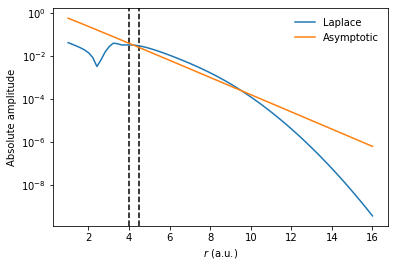

In [5]:
def asymp(r, clm):
    return clm * r**(1/kappa - 1) * np.exp(-kappa*r)

sgn, l, m = 0, 1, 1

plt.figure(facecolor='white')
plt.axvline(r_list[0], ls='--', c='k')
plt.axvline(r_list[-1], ls='--', c='k')
plt.plot(plot_list, np.abs(f_lms[:, sgn, l, m]), label='Laplace')
plt.plot(plot_list, np.abs(asymp(plot_list, clm_array[sgn, l, m])), label='Asymptotic')
plt.xlabel('$r$ (a.u.)')
plt.ylabel('Absolute amplitude')
plt.legend(frameon=False)
plt.yscale('log')
plt.show()

## Calculate PMDs

In [6]:
dp = 4. / 100
px_lst = np.arange(-1, 1, dp)
pz_lst = np.arange(-1.5, 1.5, dp)
py = 0.
px_grd, pz_grd = np.meshgrid(px_lst, pz_lst)

sfa_gto1 = sfa_lin.SFALinearPulse(Ip, Up, omega, N, CEP, 'dress_dip')
M_gto_grd1 = np.array(pool.starmap(sfa_gto1.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(all_coeffs))))
M_gto_sqr1 = np.abs(np.flip(M_gto_grd1, 0))**2
print('Done with dress_dip!')

sfa_gto2 = sfa_lin.SFALinearPulse(Ip, Up, omega, N, CEP, 'GTO_dress')
M_gto_grd2 = np.array(pool.starmap(sfa_gto2.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(all_coeffs[0]))))
M_gto_sqr2 = np.abs(np.flip(M_gto_grd2, 0))**2
print('Done with dress_GTO!')

sfa_gto3 = sfa_lin.SFALinearPulse(Ip, Up, omega, N, CEP, 'dipole')
M_gto_grd3 = np.array(pool.starmap(sfa_gto3.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(all_coeffs[1]))))
M_gto_sqr3 = np.abs(np.flip(M_gto_grd3, 0))**2
print('Done with dipole!')

Done with dress_dip!
Done with dress_GTO!
Done with dipole!


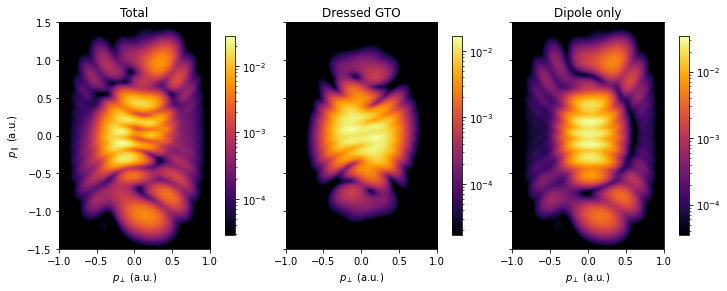

In [7]:
Ms = [M_gto_sqr1, M_gto_sqr2, M_gto_sqr3]
titles = ['Total', 'Dressed GTO', 'Dipole only']
fig, axs = plt.subplots(1, 3, facecolor='white', constrained_layout=True, figsize=(10, 8), sharey='all')
for M, ax, t in zip(Ms, axs, titles):
    img = ax.imshow(M, interpolation='bicubic', cmap='inferno',
                     norm=LogNorm(vmax=np.max(M), vmin=np.max(M)*1e-3),
                    extent=(-1, 1, -1.5, 1.5))
    plt.colorbar(img, ax=ax, shrink=0.35)
    ax.set_xlabel(r'$p_\perp$ (a.u.)')
    ax.set_title(t)
    if ax is axs[0]:
        ax.set_ylabel(r'$p_\parallel$ (a.u.)')

plt.show()